## Using  LSTM  CNN to predict travel times on a network of 16 roads (known as segments)

## 1. Get various packages

In [1]:
from   numpy                       import genfromtxt
from   sklearn.model_selection     import train_test_split
from   tflearn.layers.conv import conv_2d

import tflearn
import matplotlib
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import tensorflow        as tf

hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)


## 2. Get raw data

In [2]:
# Get all the Training data
Features_13_12_11 = genfromtxt('All_Features_for_LSTM.csv', delimiter=',')

# Select only the travel times data points (no hour, day, or month data are selected)
xx                  = Features_13_12_11[3:,:]  
number_of_segments = xx.shape[0]

## 3. Augment raw data: quadruple the data by three points interpolation between every two succesive time points

In [3]:
n                     = xx.shape[1]
A                     = np.empty((number_of_segments,4*n-3))
A[:,:]                = np.nan
index_of_xx_in_A      = range(0,4*n-3,4)

A[:,index_of_xx_in_A] = xx

df                    = pd.DataFrame(A.T)
df                    = df.interpolate()
xx = df.T.values

## 4. Smooth the data  (if window > 1)

In [4]:
x                     = pd.rolling_mean(xx, window=1, min_periods=0,axis=1)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  """Entry point for launching an IPython kernel.


## 5. Plot one of the segments (road) to spot check correctness Augmented data

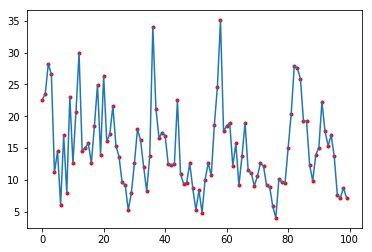

In [5]:
plt.plot(xx[3,0:100],'r.')
plt.plot( x[3,0:100])
plt.figure(figsize=(10,12))
plt.show()

## 6. Check the sizes of  raw and smoothed data

In [6]:
print(xx.shape, x.shape)

(16, 26280) (16, 26280)


## 7. Generate a time-sequenced data and set the learning rate

In [7]:
steps_of_history    =   6
steps_in_future     =   1
learning_rate       =  0.003
segments            = range(0,number_of_segments,1) 

number_travel_times = x.shape[1] 

samples             = number_travel_times - steps_of_history - steps_in_future

seq                 = np.zeros([samples, steps_of_history, number_of_segments])
next_val            = np.zeros([samples,                   number_of_segments])

for segment in range(number_of_segments):  
    for i in range(samples):
        seq     [i,:,segment] = x[ segment, i : i + steps_of_history                      ] 
        next_val[i,  segment] = x[ segment,     i + steps_of_history + steps_in_future - 1]
        
X      = seq
Y      = next_val
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.10)
print(trainX.shape,trainY.shape,testX.shape,testY.shape)

(23645, 6, 16) (23645, 16) (2628, 6, 16) (2628, 16)


## 8. Spot check the generated sequential data 

In [9]:
print(X[steps_in_future,steps_of_history-1,:])
print(Y[0,:])

[ 28.13  17.75   5.85   6.1    4.12  46.22  12.38  12.46  17.61  12.28
   9.42  43.43  62.52  62.25  17.43  74.99]
[ 28.13  17.75   5.85   6.1    4.12  46.22  12.38  12.46  17.61  12.28
   9.42  43.43  62.52  62.25  17.43  74.99]


## 9. Build an LSTM network, Train it, and then Predict Y given X (for test and training) 

In [13]:
# ----------------
# Network building
# ----------------
tf.reset_default_graph()

net = tflearn.input_data     (              shape = [None, steps_of_history, number_of_segments]
                             )
net = tflearn.lstm           ( net,       n_units = 96
                             ,         activation = 'relu'
                             ,         return_seq = False
                             )

net = tflearn.fully_connected( net,       n_units = number_of_segments
                             ,         activation = 'linear'
                             )
net = tflearn.regression     ( net,     optimizer = 'adam'
                             ,               loss = 'mean_square'
                             ,      learning_rate = learning_rate
                             )

# -----
# Train
# -----
model = tflearn.DNN          ( net
                             , tensorboard_verbose = 3
                             )
model.fit                    ( trainX, trainY
                             ,        n_epoch = 1
                             , validation_set = 0.0
                             ,     batch_size = 82
                             )


     
# -------------------------
# Predict the future values
# -------------------------
predicted_test   = model.predict(  testX )
predicted_train  = model.predict( trainX )
expected_test    = testY 
expected_train   = trainY 

Training Step: 288  | total loss: 568.20203 | time: 10.443s
| Adam | epoch: 001 | loss: 568.20203 -- iter: 23616/23645
Training Step: 289  | total loss: 565.85651 | time: 10.474s
| Adam | epoch: 001 | loss: 565.85651 -- iter: 23645/23645
--


## 10. Compute and print test and training RMSE and MAPE errors

In [14]:
from sklearn.metrics import mean_squared_error
import time

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [15]:
rmseTest  = np.sqrt(mean_squared_error(expected_test,  predicted_test ))
rmseTrain = np.sqrt(mean_squared_error(expected_train, predicted_train))

mapeTest = mean_absolute_percentage_error(expected_test,  predicted_test )
mapeTrain= mean_absolute_percentage_error(expected_train, predicted_train)

print('----------------------------')
print('Test  RMSE: %.3f' % rmseTest )
print('Test  MAPE: %.3f' % mapeTest )
print('----------------------------')
print('Train RMSE: %.3f' % rmseTrain)
print('Train MAPE: %.3f' % mapeTrain)
print('----------------------------')


time.strftime('This run was conducted on %X %x %Z')

----------------------------
Test  RMSE: 23.304
Test  MAPE: 33.014
----------------------------
Train RMSE: 23.204
Train MAPE: 32.788
----------------------------


'This run was conducted on 02:29:44 05/29/18 CDT'

## 11. Plot predict and expected travel times of first 50 steps in the 3rd segment

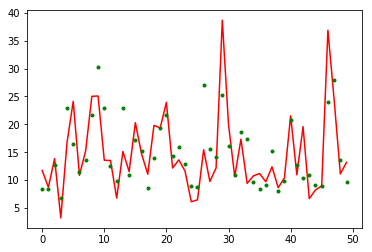

In [16]:
plt.plot( expected_test[0:50,3],'r' )
plt.plot(predicted_test[0:50,3],'g.')
plt.show()

## 12. Plot predict and expected travel times for the All segments an All times

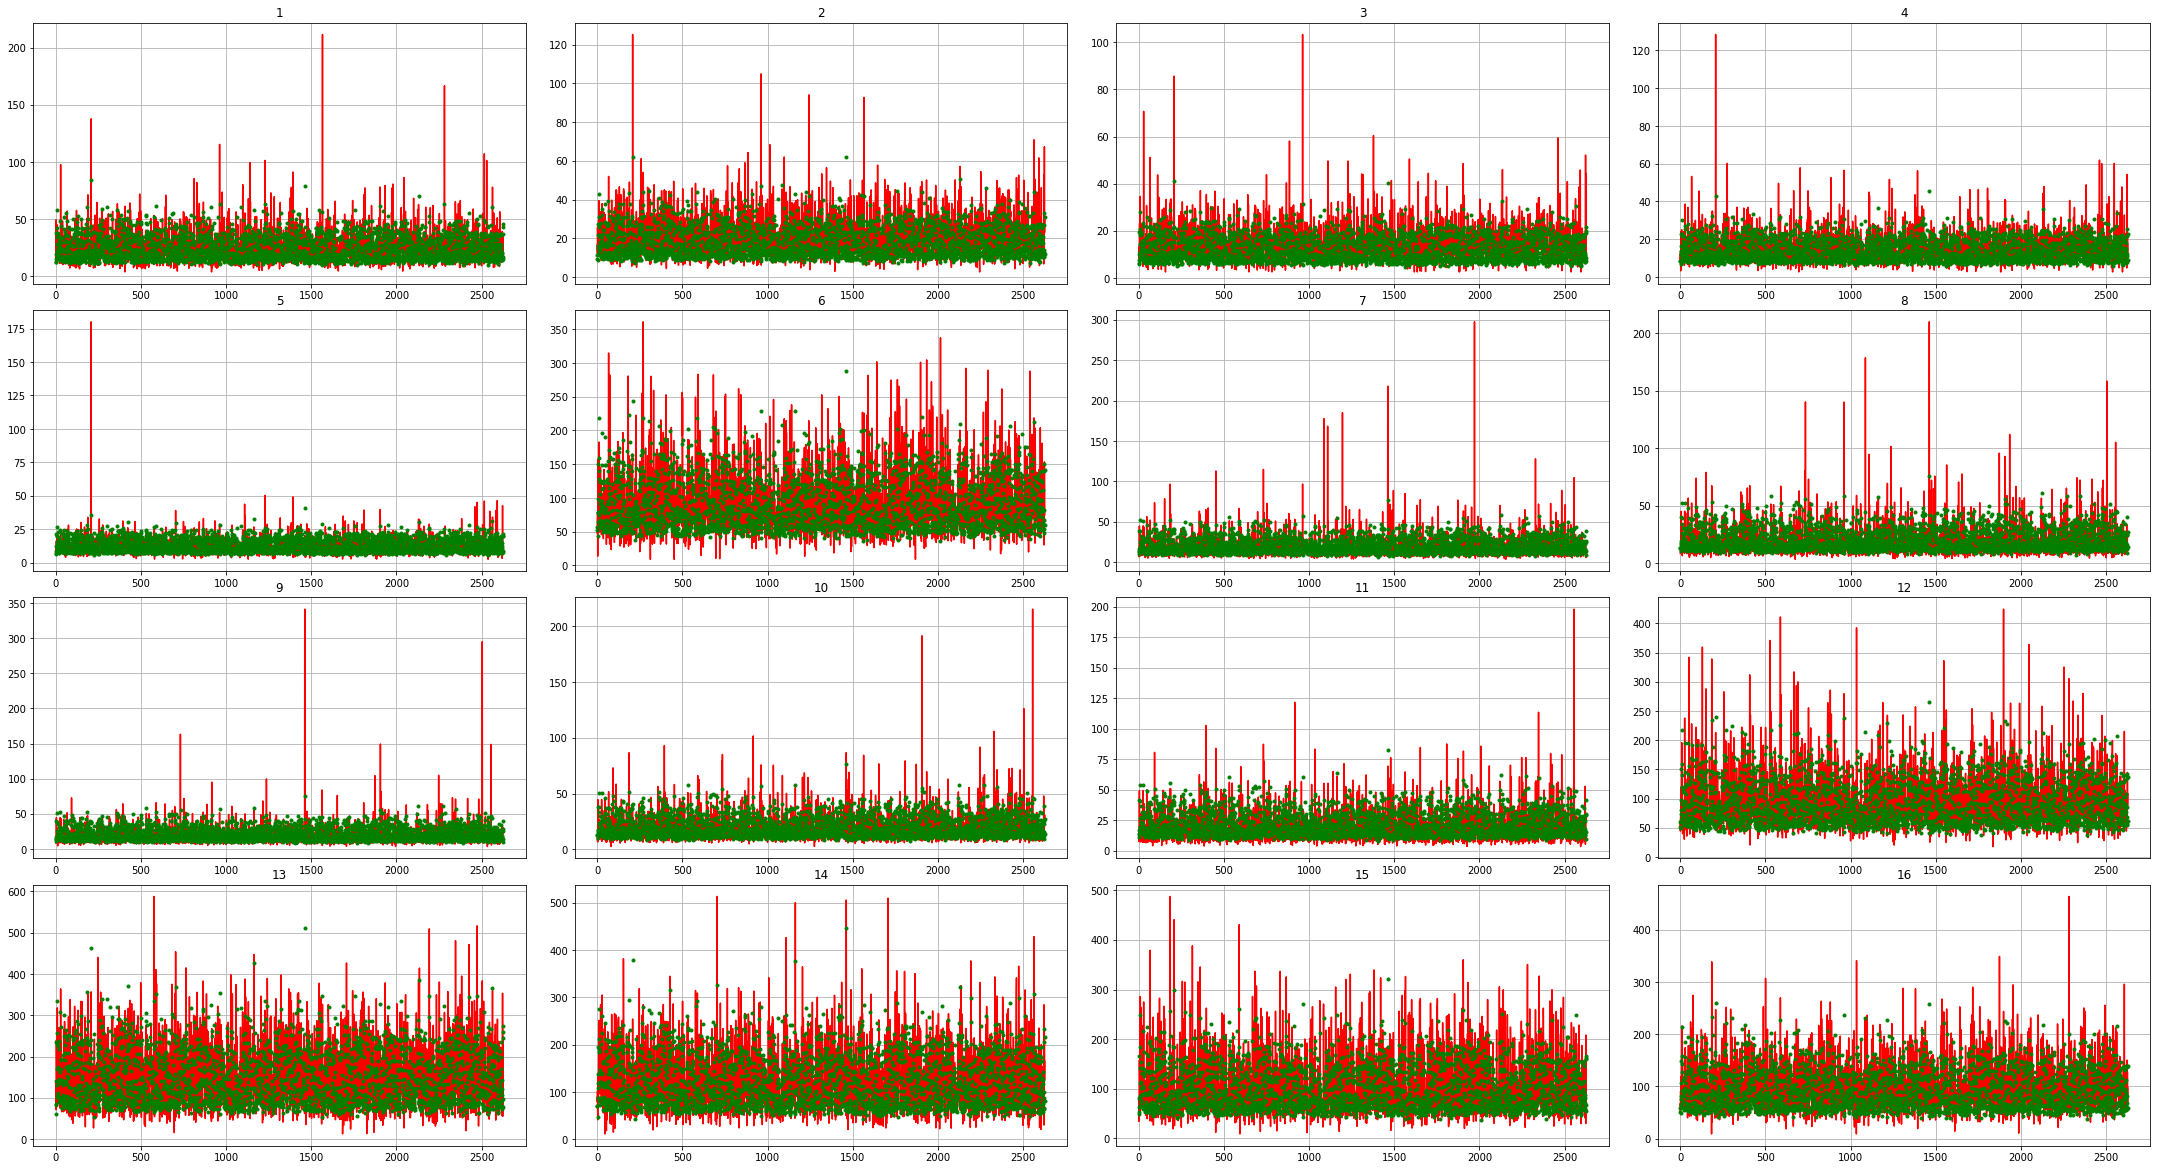

In [17]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import NullFormatter  # useful for `logit` scale

plt.figure(1)

for i in range(number_of_segments):
    plt.subplot(4,4,i+1)
    plt.plot( expected_test[:,i],'r')
    plt.plot(predicted_test[:,i],'g.')
    plt.title(str(i+1))
    plt.grid(True)

plt.gca().yaxis.set_minor_formatter(NullFormatter())
plt.subplots_adjust(top=4, bottom=0.1, left=0.1, right=5, hspace=0.1,
                    wspace=0.1)

plt.show()

## 13. Compute cross correlation

In [18]:
for i in range(number_of_segments):
    for j in range(number_of_segments):
        cij = pd.np.corrcoef(predicted_test[:,i],expected_test[:,j])
cij[0][1].mean()

0.74011088835789629